In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution

['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


# Reaction data

In [26]:
def read_reaction_data(path_to_runs: Path):
    from experiments.analysis_utils.data_processing import postprocess_proposal_data, postprocess_start_data, postprocess_timestep_data, set_run_id
    proposal_df_list, start_data_df_list, timestep_data_df_list = [], [], []
    for p_to_tables in path_to_runs.iterdir():
        proposals_p = p_to_tables.joinpath("proposals_data.parquet")
        start_data_p = p_to_tables.joinpath("common_data.parquet")
        timestep_data_p = p_to_tables.joinpath("timestep_data.parquet")
        if not proposals_p.exists() or not start_data_p.exists() or not timestep_data_p.exists():
            print(p_to_tables)
            continue
        proposals_df = pd.read_parquet(proposals_p)
        start_data_df = pd.read_parquet(start_data_p)
        timestep_data_df = pd.read_parquet(timestep_data_p)

        modeled_reactions = p_to_tables.name
        start_data_df['modeled_reactions'] = modeled_reactions

        proposal_df_list.append(proposals_df)
        start_data_df_list.append(start_data_df)
        timestep_data_df_list.append(timestep_data_df)
        
    proposal_df_full = pd.concat(proposal_df_list)
    start_data_df_full = pd.concat(start_data_df_list)
    timestep_data_df_full = pd.concat(timestep_data_df_list)

    postprocess_proposal_data(proposal_df_full)
    postprocess_start_data(start_data_df_full)
    postprocess_timestep_data(timestep_data_df_full)
    
    set_run_id(proposal_df_full, start_data_df_full, timestep_data_df_full)
    return proposal_df_full, start_data_df_full, timestep_data_df_full

# Read the data
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_modeled_reactions_study/")
# path_to_runs = Path("../../results/simulations/model_validation/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
proposal_df_full, start_data_df_full, timestep_data_df_full = read_reaction_data(path_to_runs)

/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/withdrawal_queue_replacement_modeled_reactions_study
True


In [27]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals

veto_stats = analyze_veto_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('modeled_reactions',))
print("Veto statistics by seal parameters:")
display(veto_stats)

Veto statistics by seal parameters:


veto_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions              
0.01                         0.1                           Accelerated            100.0   
                                                           Normal                 100.0   
                                                           Slowed                  97.0   

                                                                              mean_time_to_veto  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                      
0.01                         0.1                           Accelerated                22.410000   
                                                           Normal                     26.030000   
                                                           Slowed                     31.185567   

                                                                              median_time_to_veto  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                        
0.01                         0.1                           Accelerated                       23.0   
                                                           Normal                            26.0   
                                                           Slowed                            31.0   

                                                                              hours_mean_time_to_veto_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                                  
0.01                         0.1                           Accelerated                            67.230000   
                                                           Normal                                 78.090000   
                                                           Slowed                                 93.556701   

                                                                              hours_median_time_to_veto_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                                    
0.01                         0.1                           Accelerated                                   69.0   
                                                           Normal                                        78.0   
                                                           Slowed                                        93.0   

                                                                              total_runs  
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions              
0.01                         0.1                           Accelerated               100  
                                                           Normal                    100  
                                                           Slowed                    100

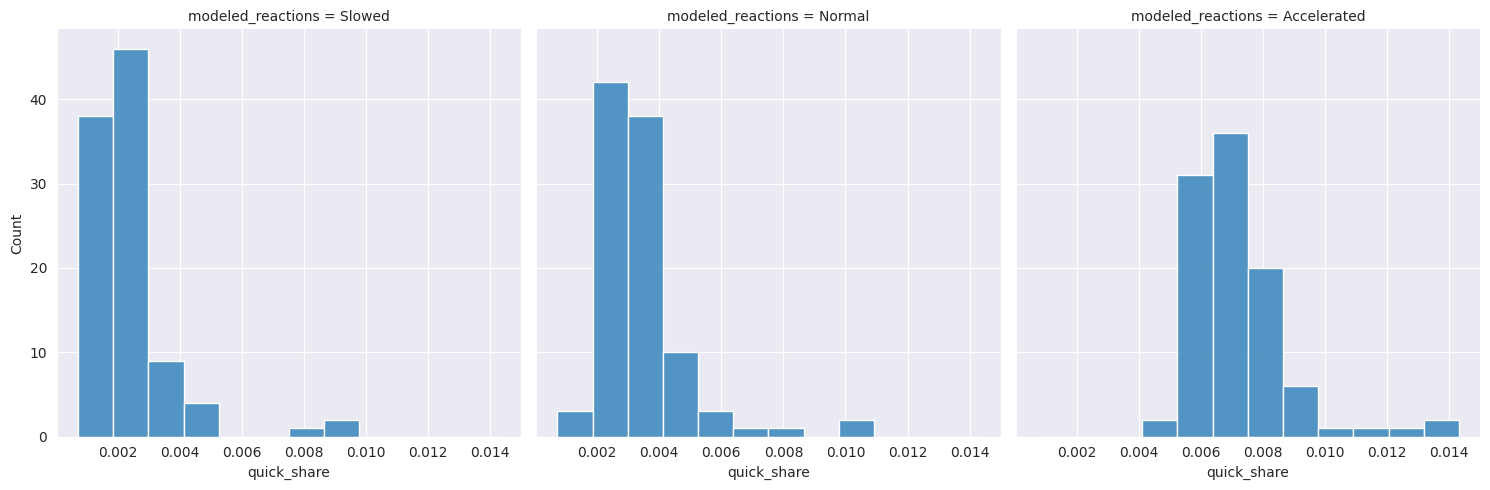

In [42]:
timestep_data_df_full_start = timestep_data_df_full[timestep_data_df_full['timestep'] == 1]
timestep_data_df_full_start = timestep_data_df_full_start.merge(start_data_df_full, on='run_id', how='left')
timestep_data_df_full_start['quick_share'] = timestep_data_df_full_start.balance_Quick / timestep_data_df_full_start.actors_total_balance
timestep_data_df_full_start['normal_share'] = timestep_data_df_full_start.balance_Normal / timestep_data_df_full_start.actors_total_balance
timestep_data_df_full_start['total_acting_share'] = timestep_data_df_full_start.quick_share + timestep_data_df_full_start.normal_share
sns.set_style('darkgrid')
sns.displot(timestep_data_df_full_start, x='quick_share', col='modeled_reactions', kind='hist')


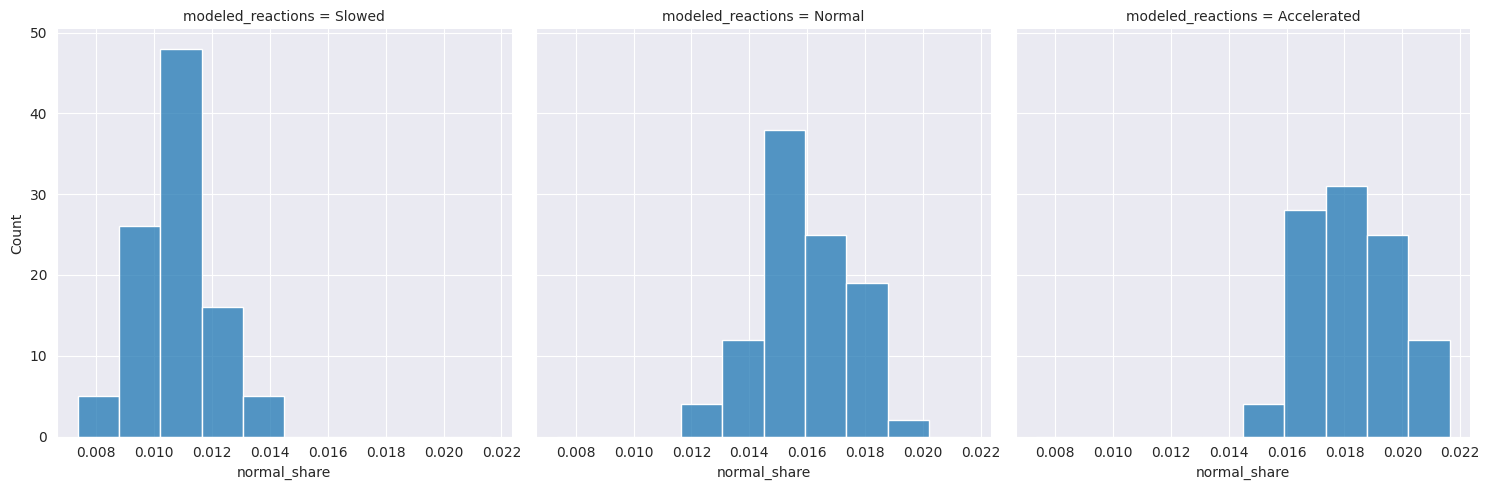

In [43]:
sns.displot(timestep_data_df_full_start, x='normal_share', col='modeled_reactions', kind='hist')


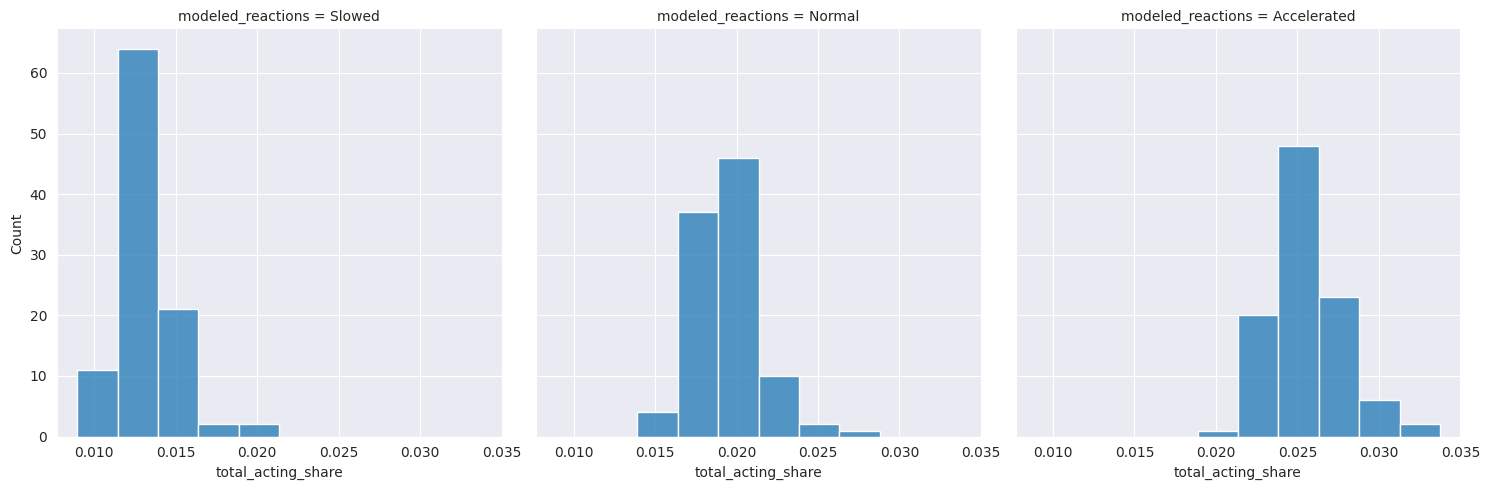

In [45]:
sns.displot(timestep_data_df_full_start, x='total_acting_share', col='modeled_reactions', kind='hist')


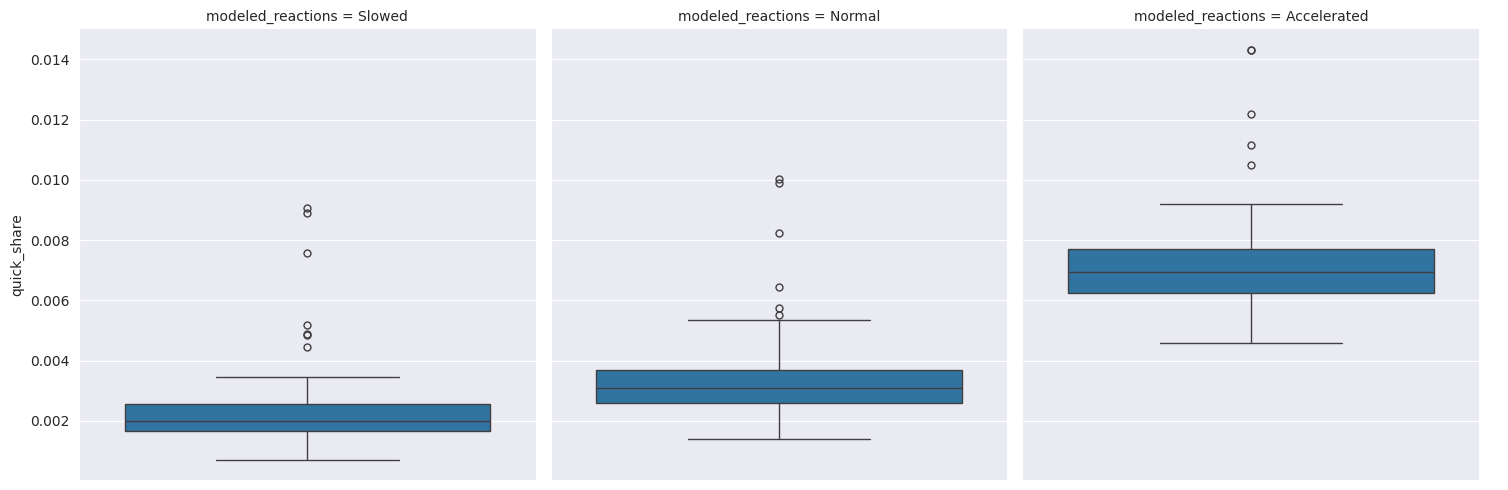

In [46]:
sns.catplot(timestep_data_df_full_start, y='quick_share', col='modeled_reactions', kind='box')

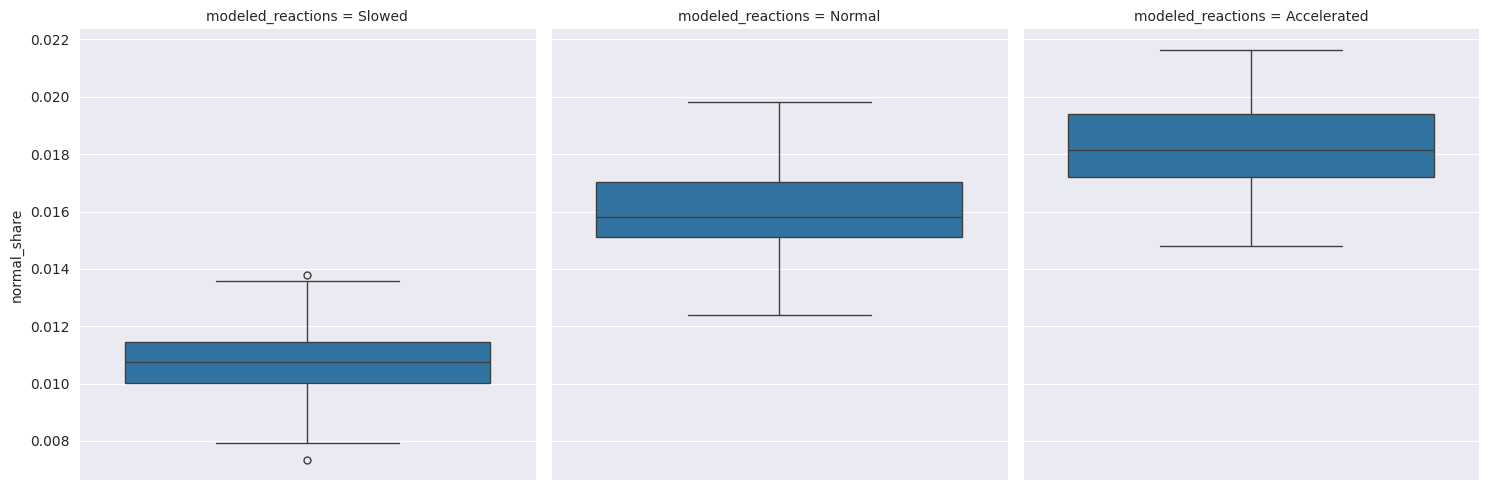

In [47]:
sns.catplot(timestep_data_df_full_start, y='normal_share', col='modeled_reactions', kind='box')

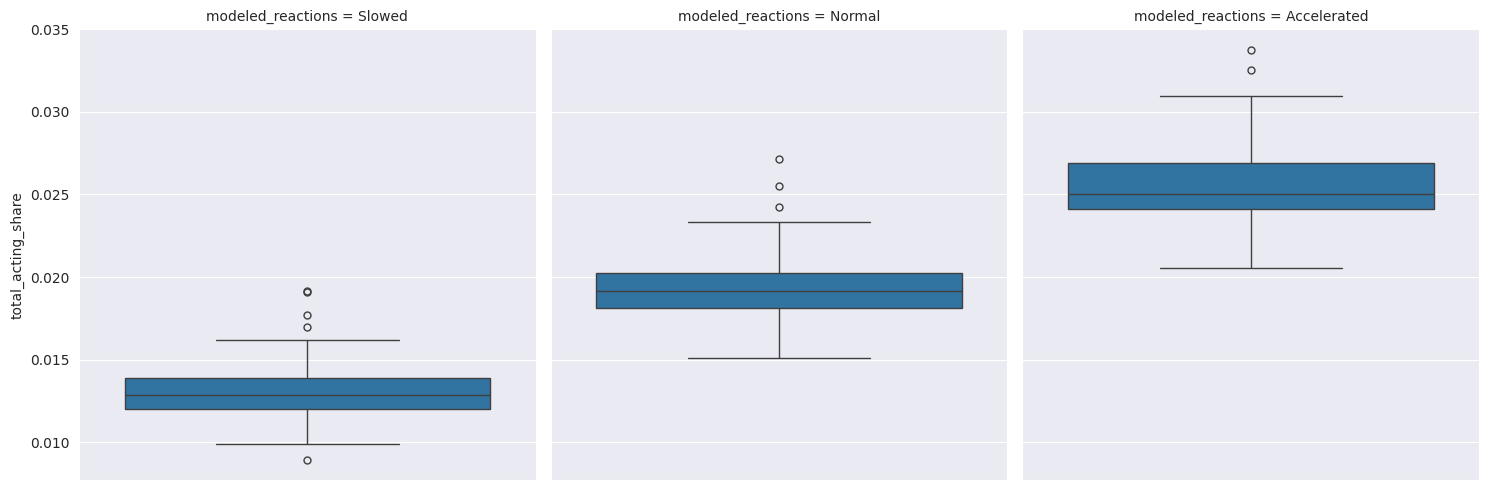

In [48]:
sns.catplot(timestep_data_df_full_start, y='total_acting_share', col='modeled_reactions', kind='box')

In [24]:
from experiments.analysis_utils.metrics import analyze_ragequit_timing_by_seals

ragequit_stats = analyze_ragequit_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('modeled_reactions',))
print("Ragequit statistics by seal parameters:")
display(ragequit_stats)

Ragequit statistics by seal parameters:


ragequit_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                  
0.01                         0.1                           Accelerated                100.0   
                                                           Normal                     100.0   
                                                           Slowed                      97.0   

                                                                              mean_time_to_ragequit  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                          
0.01                         0.1                           Accelerated                   382.410000   
                                                           Normal                        386.030000   
                                                           Slowed                        391.185567   

                                                                              median_time_to_ragequit  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                            
0.01                         0.1                           Accelerated                          383.0   
                                                           Normal                               386.0   
                                                           Slowed                               391.0   

                                                                              hours_mean_time_to_ragequit_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                                      
0.01                         0.1                           Accelerated                              1147.230000   
                                                           Normal                                   1158.090000   
                                                           Slowed                                   1173.556701   

                                                                              hours_median_time_to_ragequit_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions                                        
0.01                         0.1                           Accelerated                                     1149.0   
                                                           Normal                                          1158.0   
                                                           Slowed                                          1173.0   

                                                                              total_runs  
first_seal_rage_quit_support second_seal_rage_quit_support modeled_reactions              
0.01                         0.1                           Accelerated               100  
                                                           Normal                    100  
                                                           Slowed                    100

# Veto Seal Data

In [29]:
# Read the data
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_vetoseal_study/")
# path_to_runs = Path("../../results/simulations/model_validation/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
vetoseal_proposal_df_full, vetoseal_start_data_df_full, vetoseal_timestep_data_df_full = read_directory(path_to_runs.resolve())

/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/withdrawal_queue_replacement_vetoseal_study
True


In [30]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals

veto_stats = analyze_veto_timing_by_seals(vetoseal_timestep_data_df_full, vetoseal_start_data_df_full, additional_columns=tuple())
print("Veto statistics by seal parameters:")
display(veto_stats)

Veto statistics by seal parameters:


,,veto_rate,mean_time_to_veto,median_time_to_veto,hours_mean_time_to_veto_hours,hours_median_time_to_veto_hours,total_runs
first_seal_rage_quit_support,second_seal_rage_quit_support,,,,,,
0.0050,0.05,100.000000,21.528302,22.0,64.584906,66.0,106
0.0075,0.05,100.000000,24.028302,24.0,72.084906,72.0,106
0.0100,0.05,100.000000,26.028302,26.0,78.084906,78.0,106
0.0125,0.05,100.000000,28.226415,28.0,84.679245,84.0,106
0.0150,0.05,97.000000,30.979381,31.0,92.938144,93.0,100
0.0200,0.05,16.666667,37.437500,38.0,112.312500,114.0,96
0.0300,0.05,0.000000,NaN,NaN,NaN,NaN,96


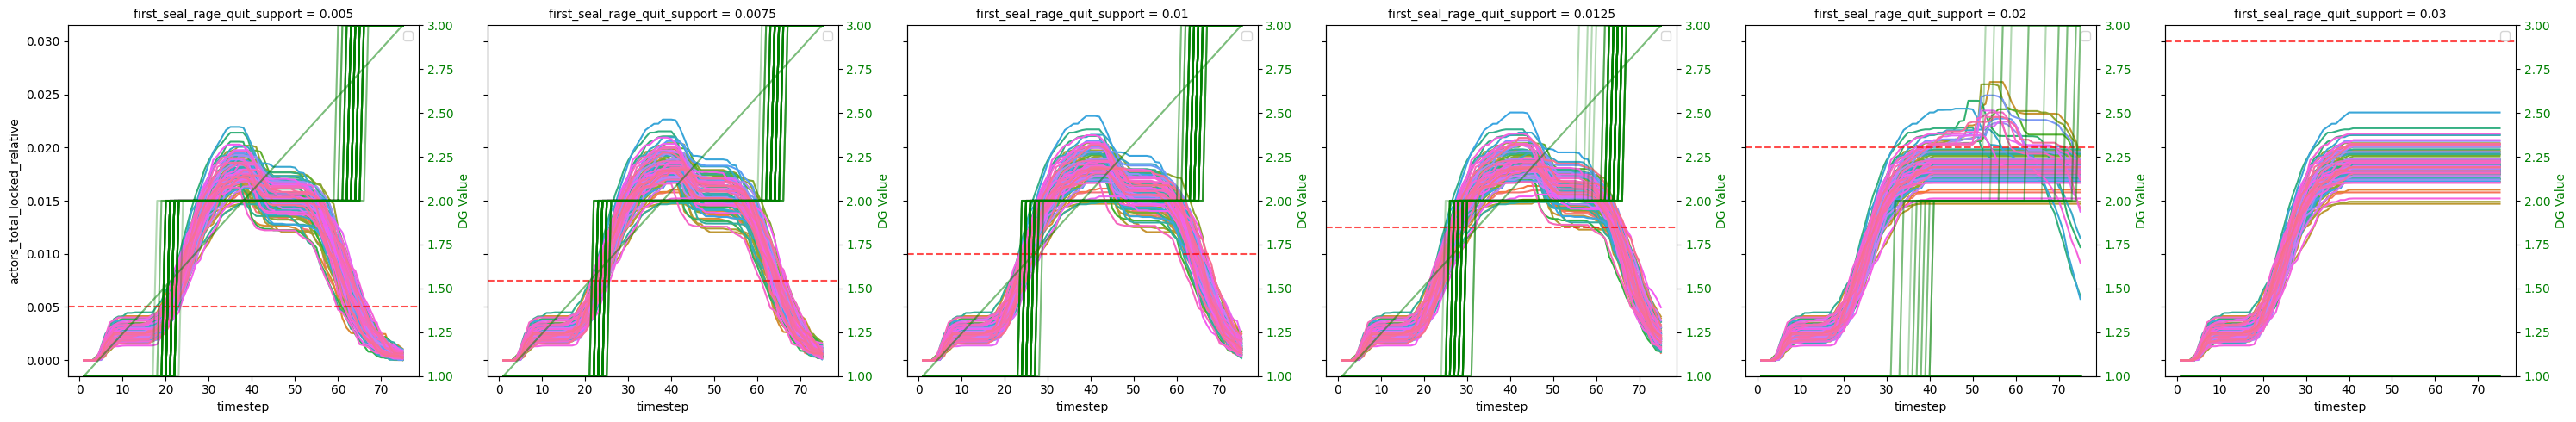

In [22]:
vetoseal_timestep_data_df_full_with_params = vetoseal_timestep_data_df_full.merge(vetoseal_start_data_df_full, on='run_id', how='left')
vetoseal_timestep_data_df_full_with_params['run_str'] = vetoseal_timestep_data_df_full_with_params['run_id'].astype(str)
# Create the main plot
g = sns.relplot(vetoseal_timestep_data_df_full_with_params, 
                x='timestep', 
                y='actors_total_locked_relative', 
                col='first_seal_rage_quit_support', 
                kind='line', 
                estimator=None, 
                hue='run_str',
                legend=False)

# Add horizontal lines and secondary axis for each subplot
for ax, seal_value in zip(g.axes.flat, g.col_names):
    # Add the horizontal threshold line
    ax.axhline(y=float(seal_value), 
               color='red', 
               linestyle='--', 
               alpha=0.7, 
               label=f'Seal threshold: {float(seal_value):.3f}')
    
    # Create secondary y-axis
    ax2 = ax.twinx()
    
    # Plot DG value on secondary axis
    subset = vetoseal_timestep_data_df_full_with_params[
        vetoseal_timestep_data_df_full_with_params['first_seal_rage_quit_support'] == float(seal_value)
    ]
    for run_str in subset['run_str'].unique():
        run_str_data = subset[subset['run_str'] == run_str]
        ax2.plot(run_str_data['timestep'], 
                run_str_data['dg_state_value'],
                color='green',
                alpha=0.3)
    ax2.set_ylim(1, 3)
    
    # Customize secondary axis
    ax2.set_ylabel('DG Value', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Add legends
    ax.legend([], [])

plt.tight_layout()


# RageQuit data

In [2]:
# Read the data
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_rageseal_study/")
# path_to_runs = Path("../../results/simulations/model_validation/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
ragequit_proposal_df_full, ragequit_start_data_df_full, ragequit_timestep_data_df_full = read_directory(path_to_runs.resolve())

/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/withdrawal_queue_replacement_rageseal_study
True


In [3]:
from experiments.analysis_utils.metrics import analyze_ragequit_timing_by_seals

ragequit_stats = analyze_ragequit_timing_by_seals(ragequit_timestep_data_df_full, ragequit_start_data_df_full, additional_columns=tuple())
print("Ragequit statistics by seal parameters:")
display(ragequit_stats)

Ragequit statistics by seal parameters:


ragequit_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support                  
0.005                        0.050                                  100.0   
                             0.075                                  100.0   
                             0.100                                  100.0   
                             0.125                                  100.0   
                             0.150                                  100.0   

                                                            mean_time_to_ragequit  \
first_seal_rage_quit_support second_seal_rage_quit_support                          
0.005                        0.050                                         381.56   
                             0.075                                         381.56   
                             0.100                                         381.56   
                             0.125                                         381.56   
                             0.150                                         381.56   

                                                            median_time_to_ragequit  \
first_seal_rage_quit_support second_seal_rage_quit_support                            
0.005                        0.050                                            382.0   
                             0.075                                            382.0   
                             0.100                                            382.0   
                             0.125                                            382.0   
                             0.150                                            382.0   

                                                            hours_mean_time_to_ragequit_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support                                      
0.005                        0.050                                                    1144.68   
                             0.075                                                    1144.68   
                             0.100                                                    1144.68   
                             0.125                                                    1144.68   
                             0.150                                                    1144.68   

                                                            hours_median_time_to_ragequit_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support                                        
0.005                        0.050                                                       1146.0   
                             0.075                                                       1146.0   
                             0.100                                                       1146.0   
                             0.125                                                       1146.0   
                             0.150                                                       1146.0   

                                                            total_runs  
first_seal_rage_quit_support second_seal_rage_quit_support              
0.005                        0.050                                 100  
                             0.075                                 100  
                             0.100                                 100  
                             0.125                                 100  
                             0.150                                 100

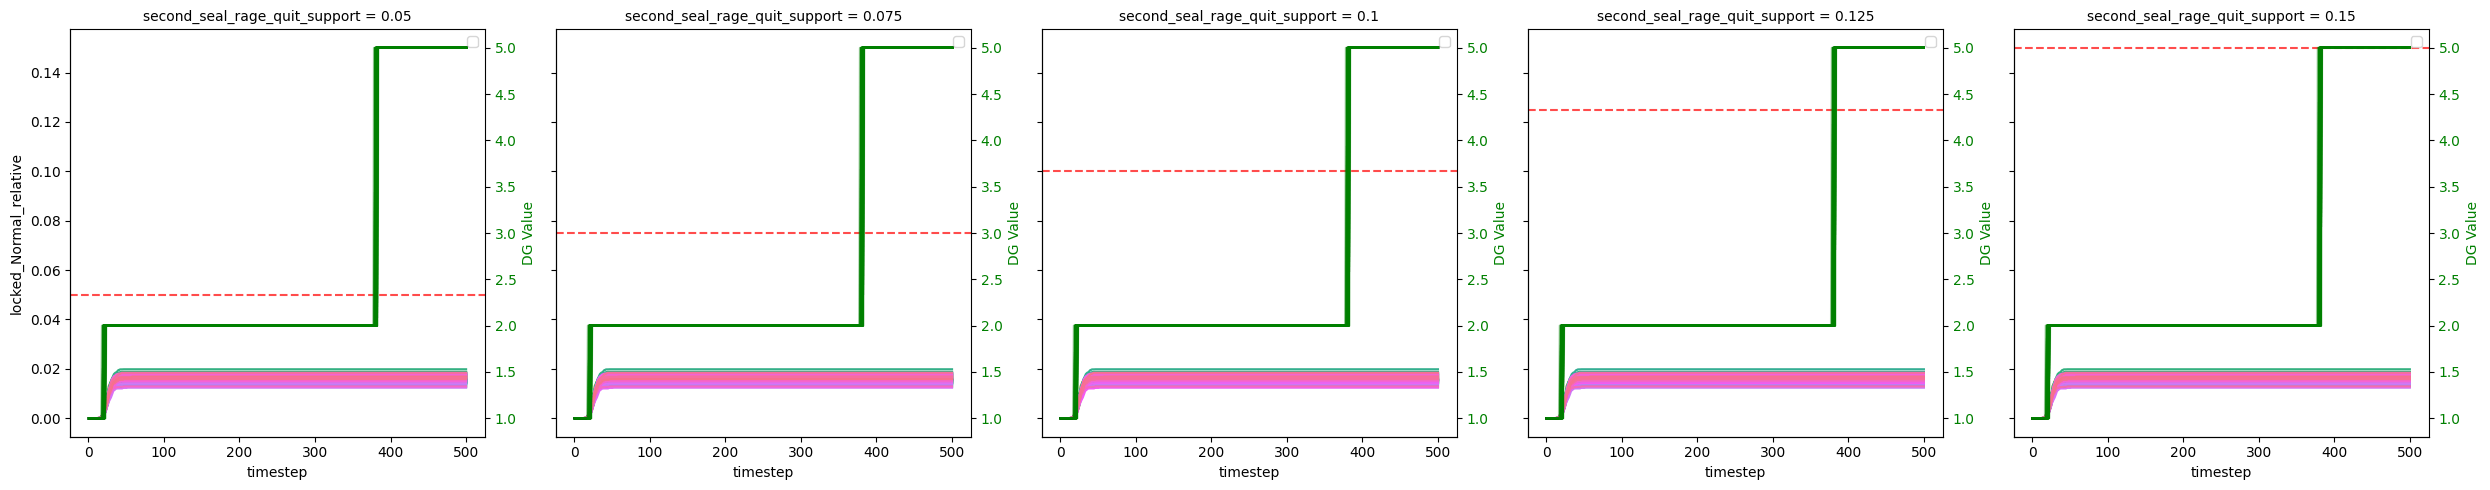

In [28]:
ragequit_timestep_data_df_full_with_params = ragequit_timestep_data_df_full.merge(ragequit_start_data_df_full, on='run_id', how='left')
ragequit_timestep_data_df_full_with_params['run_str'] = ragequit_timestep_data_df_full_with_params['run_id'].astype(str)
# Get the initial balance for each run_id
initial_balances = ragequit_timestep_data_df_full_with_params[
    ragequit_timestep_data_df_full_with_params['timestep'] == 1
][['run_id', 'actors_total_balance']].set_index('run_id')

# Create the relative column by dividing by the corresponding initial balance
ragequit_timestep_data_df_full_with_params['locked_Normal_relative'] = (
    ragequit_timestep_data_df_full_with_params['locked_Normal'] / 
    ragequit_timestep_data_df_full_with_params['run_id'].map(initial_balances['actors_total_balance'])
)
# Create the main plot
g = sns.relplot(ragequit_timestep_data_df_full_with_params, 
                x='timestep', 
                y='locked_Normal_relative', 
                col='second_seal_rage_quit_support', 
                kind='line', 
                estimator=None, 
                hue='run_str', legend=False)

# Add horizontal lines and secondary axis for each subplot
for ax, seal_value in zip(g.axes.flat, g.col_names):
    # Add the horizontal threshold line
    ax.axhline(y=float(seal_value), 
               color='red', 
               linestyle='--', 
               alpha=0.7, 
               label=f'Seal threshold: {float(seal_value):.3f}')
    
    # Create secondary y-axis
    ax2 = ax.twinx()
    
    # Plot DG value on secondary axis
    subset = ragequit_timestep_data_df_full_with_params[
        ragequit_timestep_data_df_full_with_params['second_seal_rage_quit_support'] == float(seal_value)
    ]
    for run_str in subset['run_str'].unique():
        run_str_data = subset[subset['run_str'] == run_str]
        ax2.plot(run_str_data['timestep'], 
                run_str_data['dg_state_value'],
                color='green',
                alpha=0.3)
    
    # Customize secondary axis
    ax2.set_ylabel('DG Value', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Add legends
    ax.legend([], [])

plt.tight_layout()


In [25]:
[col for col in ragequit_timestep_data_df_full.columns if 'Slow' in col]

['balance_Slow',
 'hypothetical_balanceSlow',
 'locked_Slow',
 'health_Slow',
 'hypothetical_health_Slow',
 'cropped_health_Slow',
 'damage_Slow',
 'healing_Slow',
 'recovery_Slow',
 'actors_locked_Slow',
 'actors_affected_Slow',
 'actors_quit_Slow',
 'quit_Slow']

# Plot demostrating the escrow and dg states

In [165]:
# Read the data
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
ragequit_proposal_df_full, ragequit_start_data_df_full, ragequit_timestep_data_df_full = read_directory(path_to_runs.resolve())
ragequit_timestep_data_df_full_with_params = ragequit_timestep_data_df_full.merge(ragequit_start_data_df_full, on='run_id', how='left')

/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/withdrawal_queue_replacement
True


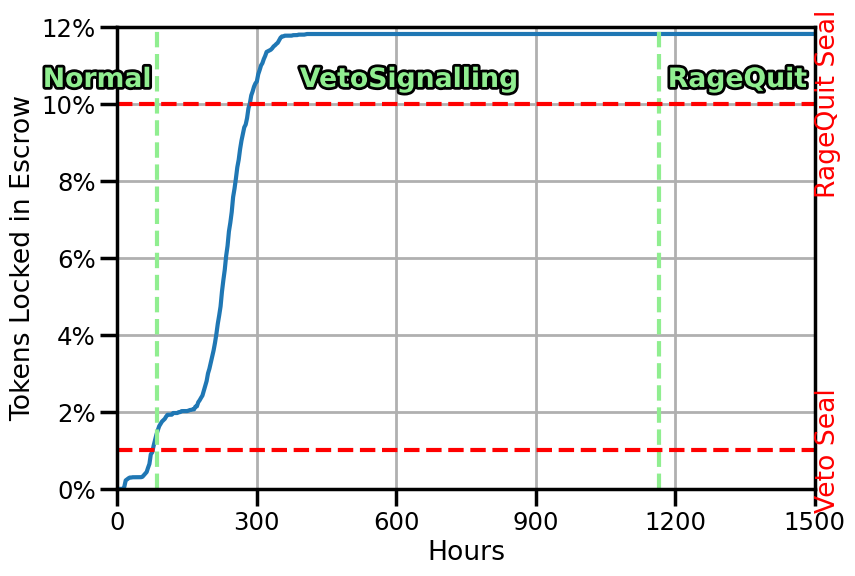

In [229]:
import matplotlib.ticker
import matplotlib.patheffects as pe

sns.set_context('poster', font_scale=0.8)
first_seal = 0.01
second_seal = 0.1
g = ragequit_timestep_data_df_full_with_params[ragequit_timestep_data_df_full_with_params['second_seal_rage_quit_support'] == second_seal].groupby('run_id')
run_df = g.get_group(list(g.groups)[20])

basesize = 6
aspect = 1.5
fig, ax = plt.subplots(figsize=(aspect * basesize, basesize))
run_df.plot(x='timestep', y='actors_total_locked_relative', ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel('Tokens Locked in Escrow')
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: f'{x * 3:.0f}'))
ax.set_xlabel('Hours')

timestep_veto_start = run_df[run_df['dg_state_name'] == 'VetoSignalling']['timestep'].min()
timestep_ragequit_start = run_df[run_df['dg_state_name'] == 'RageQuit']['timestep'].min()
ylim = ax.get_ylim()
ylim = [0, 0.12]
ax.plot(np.repeat(timestep_veto_start-0.5, 2), ylim, linestyle='--', color='lightgreen')
ax.plot(np.repeat(timestep_ragequit_start-0.5, 2), ylim, linestyle='--', color='lightgreen')
ax.set_ylim(ylim)

xlim = ax.get_xlim()
xlim = [0, 500]

dg_state_text_kwargs = {'ha': 'center', 'color': 'lightgreen', 'weight': 'bold', 'path_effects': [pe.withStroke(linewidth=4, foreground="black")]}
y_text_coord = (ylim[1] - ylim[0]) * .87
normal_text_x_coord = (xlim[0] + timestep_veto_start) / 2 * -1
ax.text(normal_text_x_coord, y_text_coord, 'Normal', **dg_state_text_kwargs)

veto_text_x_coord = (timestep_ragequit_start + timestep_veto_start) / 2
ax.text(veto_text_x_coord, y_text_coord, 'VetoSignalling', **dg_state_text_kwargs)


rage_text_x_coord = (xlim[1] + timestep_ragequit_start) / 2
ax.text(rage_text_x_coord, y_text_coord, 'RageQuit', **dg_state_text_kwargs)
ax.plot(xlim, np.repeat(first_seal, 2), linestyle='--', color='red')
seal_text_x_coord = 500
seal_text_kwargs = {'color': 'red', 'rotation': 90, 'va': 'center'}
ax.text(500, first_seal, 'Veto Seal', **seal_text_kwargs)
ax.plot(xlim, np.repeat(second_seal, 2), linestyle='--', color='red')
ax.text(500, second_seal, 'RageQuit Seal', **seal_text_kwargs)
ax.set_xlim(xlim)
ax.get_legend().remove()
ax.grid()

<Axes: xlabel='timestep'>

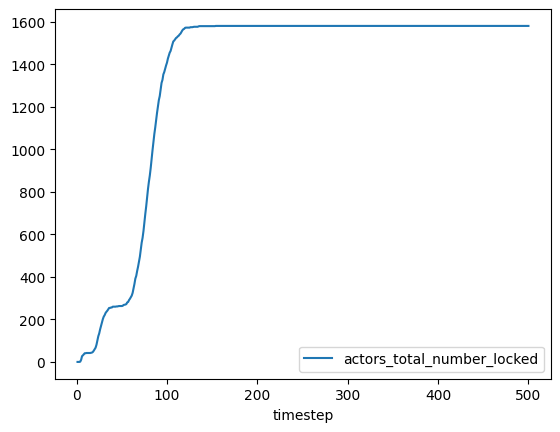

In [168]:
run_df.plot(x='timestep', y='actors_total_number_locked')

In [169]:
ragequit_timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: (x['dg_state_name'] == 'VetoSignalling').any())

/tmp/ipykernel_11842/2122102869.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ragequit_timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: (x['dg_state_name'] == 'VetoSignalling').any())


run_id
0     True
1     True
2     True
3     True
4     True
      ... 
95    True
96    True
97    True
98    True
99    True
Length: 100, dtype: bool

In [160]:
counts = ragequit_timestep_data_df_full_with_params.groupby('run_id').agg({'dg_dynamic_timelock_seconds': 'max'})
counts.iloc[counts.dg_dynamic_timelock_seconds.argmax()]

dg_dynamic_timelock_seconds    0
Name: 0, dtype: int64

In [154]:
(counts > 0).sum()

dg_dynamic_timelock_seconds    1
dtype: int64

In [138]:
ragequit_timestep_data_df_full_with_params[ragequit_timestep_data_df_full_with_params['run_id'] == 20]

,timestep,simulation_hash_x,dg_state_value,dg_state_name,dg_rage_quit_support,dg_dynamic_timelock_seconds,actors_total_balance,actors_total_locked,actors_total_number,actors_total_number_locked,...,NoReaction,BaseActor,HonestActor,SingleAttacker,CoordinatedAttacker,Hacker,SingleDefender,CoordinatedDefender,initial_total_balance,attacker_share
10000,1,c9ad284cad1c3cd98c0bf5438e3ad7cc79d406490f3cca...,1,Normal,0,0,8.996417e+06,0.000000e+00,1986,0,...,182,0,1983,3,0,0,0,0,8.996417e+06,0.0
10001,2,c9ad284cad1c3cd98c0bf5438e3ad7cc79d406490f3cca...,1,Normal,0,0,8.996417e+06,0.000000e+00,1986,0,...,182,0,1983,3,0,0,0,0,8.996417e+06,0.0
10002,3,c9ad284cad1c3cd98c0bf5438e3ad7cc79d406490f3cca...,1,Normal,0,0,8.996417e+06,0.000000e+00,1986,0,...,182,0,1983,3,0,0,0,0,8.996417e+06,0.0
10003,4,c9ad284cad1c3cd98c0bf5438e3ad7cc79d406490f3cca...,1,Normal,15758273863098,0,8.996275e+06,1.417680e+02,1986,1,...,182,0,1983,3,0,0,0,0,8.996417e+06,0.0
10004,5,c9ad284cad1c3cd98c0bf5438e3ad7cc79d406490f3cca...,1,Normal,278084061220480,0,8.993915e+06,2.501760e+03,1986,4,...,182,0,1983,3,0,0,0,0,8.996417e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,496,c9ad284cad1c3cd98c0bf5438e3ad7cc79d406490f3cca...,5,RageQuit,0,0,6.929967e+06,2.066449e+06,1986,1147,...,182,0,1983,3,0,0,0,0,8.996417e+06,0.0
10496,497,c9ad284cad1c3cd98c0bf5438e3ad7cc79d406490f3cca...,5,RageQuit,0,0,6.929967e+06,2.066449e+06,1986,1147,...,182,0,1983,3,0,0,0,0,8.996417e+06,0.0
10497,498,c9ad284cad1c3cd98c0bf5438e3ad7cc79d406490f3cca...,5,RageQuit,0,0,6.929967e+06,2.066449e+06,1986,1147,...,182,0,1983,3,0,0,0,0,8.996417e+06,0.0
10498,499,c9ad284cad1c3cd98c0bf5438e3ad7cc79d406490f3cca...,5,RageQuit,0,0,6.929967e+06,2.066449e+06,1986,1147,...,182,0,1983,3,0,0,0,0,8.996417e+06,0.0


In [137]:
counts

,dg_dynamic_timelock_seconds
run_id,
0,0
1,0
2,0
3,0
4,0
...,...
95,0
96,0
97,0
